In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats as sp_stats

plt.rcParams['svg.fonttype'] = 'none'

In [2]:
construct_stats = pd.read_csv('constructs_df.csv')

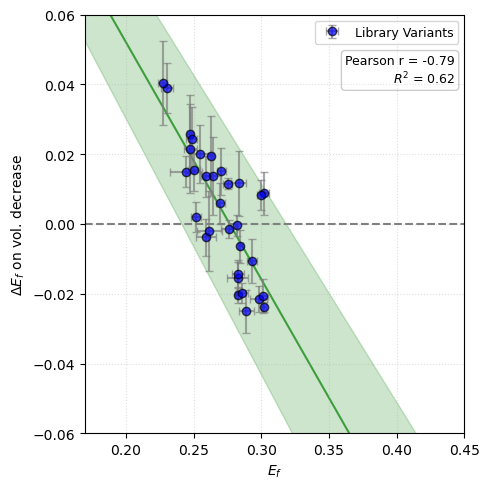

In [3]:
# plot Ef_cell vs Ef_cell_delta with error bars - BLUE POINTS ONLY (constructs 1-32)
mask = construct_stats[['Ef_cell', 'Ef_cell_std', 'Ef_cell_delta', 'Ef_cell_delta_std']].notnull().all(axis=1)
plot_df = construct_stats.loc[mask]

# Filter for only blue points (constructs < 35)
blue_mask = plot_df['construct'] < 35
plot_df_blue = plot_df[blue_mask]

x = plot_df_blue['Ef_cell']
y = plot_df_blue['Ef_cell_delta']
xerr = plot_df_blue['Ef_cell_std']
yerr = plot_df_blue['Ef_cell_delta_std']

fig, ax = plt.subplots(figsize=(5, 5))

# Plot blue points (Library Variants)
ax.errorbar(x, y, xerr=xerr, yerr=yerr, 
            fmt='o', color='blue', markeredgecolor='black', markeredgewidth=1,
            ecolor='grey', capsize=3, alpha=0.7, label='Library Variants')

# Linear regression for line of best fit
slope, intercept, r_value, p_value, std_err = sp_stats.linregress(x, y)

# Calculate Pearson correlation
pearson_r, pearson_p = sp_stats.pearsonr(x, y)

# Use the plot x-limits for the line
line_x = np.array([.17, .45])
line_y = slope * line_x + intercept

# Plot line of best fit
ax.plot(line_x, line_y, color='green', linestyle='-', linewidth=1.5, alpha=0.7, zorder=1)

# Calculate 95% confidence interval using prediction interval
n = len(x)
dof = n - 2  # degrees of freedom
t_val = sp_stats.t.ppf(0.975, dof)  # 95% confidence interval

# Calculate standard error of prediction
x_mean = np.mean(x)
sxx = np.sum((x - x_mean)**2)
predict_y = slope * x + intercept
residuals = y - predict_y
s_resid = np.sqrt(np.sum(residuals**2) / dof)

# Prediction interval (wider at extremes)
se_line = s_resid * np.sqrt(1/n + (line_x - x_mean)**2 / sxx)
margin = t_val * se_line

# Shade prediction interval
ax.fill_between(line_x, line_y - margin, line_y + margin, 
                color='green', alpha=0.2, zorder=0)

ax.axhline(0, linestyle='--', color='gray')  # dashed horizontal line at y=0

ax.set_xlabel('$E_{f}$')
ax.set_ylabel('Δ$E_{f}$ on vol. decrease')
ax.grid(True, linestyle=':', alpha=0.4)

# Add legend to top right
ax.legend(loc='upper right', frameon=True, fontsize=9)

# Add R² and Pearson correlation text below legend
ax.text(0.975, 0.905, f'Pearson r = {pearson_r:.2f}\n$R^2$ = {r_value**2:.2f}', 
        transform=ax.transAxes, fontsize=9, verticalalignment='top', 
        horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.2))

plt.xlim(.17, .45)
plt.ylim(-.06, .06)

plt.tight_layout()
plt.savefig('Figure_graphs/Fig3/Ef_vs_deltaEf_1-32.svg')

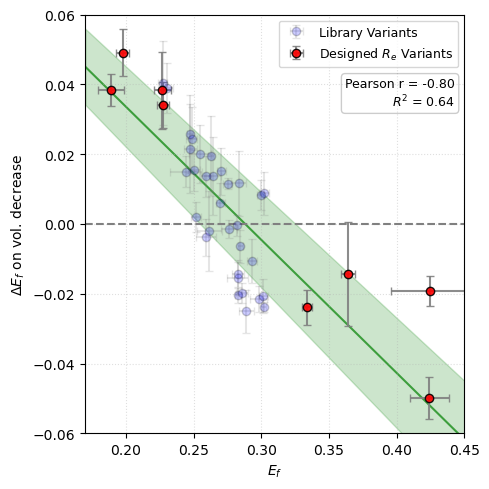

In [4]:
# plot Ef_cell vs Ef_cell_delta with error bars
mask = construct_stats[['Ef_cell', 'Ef_cell_std', 'Ef_cell_delta', 'Ef_cell_delta_std']].notnull().all(axis=1)
plot_df = construct_stats.loc[mask]

x = plot_df['Ef_cell']
y = plot_df['Ef_cell_delta']
xerr = plot_df['Ef_cell_std']
yerr = plot_df['Ef_cell_delta_std']

# Separate data into two groups
blue_mask = plot_df['construct'] < 35
red_mask = (plot_df['construct'] >= 35) & (plot_df['construct'] <= 42)

fig, ax = plt.subplots(figsize=(5, 5))

# Plot blue points (Library Variants)
ax.errorbar(x[blue_mask], y[blue_mask], xerr=xerr[blue_mask], yerr=yerr[blue_mask], 
            fmt='o', color='blue', markeredgecolor='black', markeredgewidth=1,
            ecolor='grey', capsize=3, alpha=0.2, label='Library Variants')

# Plot red points (Designed Re Variants)
ax.errorbar(x[red_mask], y[red_mask], xerr=xerr[red_mask], yerr=yerr[red_mask], 
            fmt='o', color='red', markeredgecolor='black', markeredgewidth=1,
            ecolor='grey', capsize=3, alpha=0.9, label='Designed $R_e$ Variants')

# Linear regression for line of best fit
slope, intercept, r_value, p_value, std_err = sp_stats.linregress(x, y)

# Calculate Pearson correlation
pearson_r, pearson_p = sp_stats.pearsonr(x, y)

# Use the plot x-limits for the line
line_x = np.array([.17, .45])
line_y = slope * line_x + intercept

# Plot line of best fit
ax.plot(line_x, line_y, color='green', linestyle='-', linewidth=1.5, alpha=0.7, zorder=1)

# Calculate 95% confidence interval using prediction interval
n = len(x)
dof = n - 2  # degrees of freedom
t_val = sp_stats.t.ppf(0.975, dof)  # 95% confidence interval

# Calculate standard error of prediction
x_mean = np.mean(x)
sxx = np.sum((x - x_mean)**2)
predict_y = slope * x + intercept
residuals = y - predict_y
s_resid = np.sqrt(np.sum(residuals**2) / dof)

# Prediction interval (wider at extremes)
se_line = s_resid * np.sqrt(1/n + (line_x - x_mean)**2 / sxx)
margin = t_val * se_line

# Shade prediction interval
ax.fill_between(line_x, line_y - margin, line_y + margin, 
                color='green', alpha=0.2, zorder=0)

ax.axhline(0, linestyle='--', color='gray')  # dashed horizontal line at y=0

ax.set_xlabel('$E_{f}$')
ax.set_ylabel('Δ$E_{f}$ on vol. decrease')
ax.grid(True, linestyle=':', alpha=0.4)

# Add legend to top right
ax.legend(loc='upper right', frameon=True, fontsize=9)

# Add R² and Pearson correlation text below legend
ax.text(0.975, 0.85, f'Pearson r = {pearson_r:.2f}\n$R^2$ = {r_value**2:.2f}', 
        transform=ax.transAxes, fontsize=9, verticalalignment='top', 
        horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.2))

plt.xlim(.17, .45)
plt.ylim(-.06, .06)

plt.tight_layout()
plt.savefig('Figure_graphs/Fig3/Ef_vs_deltaEf_1-40.svg')